# Dependencies

In [1]:
!pip install datasets evaluate > /dev/null 2>&1

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# drive = "/content/drive/MyDrive"

drive = "."

In [3]:
# ── Standard Library ───────────────────────────────────────────────────────────
import os
import sys
import uuid
import json
import zipfile
import pickle
from collections import OrderedDict
import logging

# ── Third‑Party Libraries ─────────────────────────────────────────────────────
import numpy as np
import random
import pandas as pd
import string
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import evaluate
from evaluate import load

# ── PyTorch ────────────────────────────────────────────────────────────────────
import torch
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import wordnet

# ── Hugging Face Transformers ─────────────────────────────────────────────────
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    logging as hf_logging
)

# ── Hugging Face Datasets ─────────────────────────────────────────────────────
from datasets import Dataset as HFDataset, load_dataset

# ── PEFT (Parameter‑Efficient Fine‑Tuning) ─────────────────────────────────────
from peft import (
    PeftModel,
    PeftConfig,
    LoraConfig,
    TaskType,
    get_peft_model,
)

# ── Safetensors ────────────────────────────────────────────────────────────────
from safetensors.torch import load_file

# ── Logging Configuration ─────────────────────────────────────────────────────
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(message)s",
    level=logging.INFO,
)
log = logging.getLogger(__name__)

# os.environ["TRANSFORMERS_VERBOSITY"] = "error"
# hf_logging.set_verbosity_error()

2025-04-21 15:26:44.653865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745249204.846823      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745249204.902298      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [5]:
# Define Kaggle credentials
kaggle_creds = {
    "username": "hurryingauto3",
    "key": "17e33c07cfd0993aecbc770b33c7054e"
}

# Ensure the Kaggle config directory exists
os.makedirs(os.path.expanduser("~/.config/kaggle/"), exist_ok=True)

# Write credentials to kaggle.json
with open(os.path.expanduser("~/.config/kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_creds, f)

# Set correct permissions
os.chmod(os.path.expanduser("~/.config/kaggle/kaggle.json"), 0o600)

# Remove the "data/" directory if it exists
os.system("rm -rf data/")

# --- Kaggle API ---
from kaggle.api.kaggle_api_extended import KaggleApi

In [6]:
def synonym_replacement(text, n=1):
    """Replace n words in the sentence with their synonyms using WordNet."""
    words = text.split()
    new_words = words.copy()
    # Filter out short words and potentially common stop words if desired
    random_word_list = list(set([word for word in words if len(word) > 3])) # Keep simple filter
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            # Get lemmas from the first synset
            syn_words = [lemma.name() for lemma in synonyms[0].lemmas()]
            # Filter out the original word itself if it appears as a synonym
            syn_words = [s.replace('_', ' ') for s in syn_words if s.lower() != random_word.lower()]
            if syn_words:
                synonym = random.choice(syn_words) # Choose a random synonym
                # More robust replacement (case-insensitive match)
                for i, word in enumerate(new_words):
                    if word.lower() == random_word.lower():
                        new_words[i] = synonym
                num_replaced += 1
        if num_replaced >= n:
            break
    return " ".join(new_words)

def word_dropout(text, dropout_prob=0.1):
    """Randomly drops words with a given probability."""
    words = text.split()
    if not words: return "" # Handle empty strings
    # Keep at least one word if dropout_prob is high
    survivors = [word for word in words if random.random() > dropout_prob]
    if not survivors and words: # Ensure at least one word remains if original wasn't empty
        return random.choice(words)
    return " ".join(survivors)

def random_swap(text, n=1):
    """Randomly swaps two words n times."""
    words = text.split()
    length = len(words)
    if length < 2: # Cannot swap if less than 2 words
        return text
    for _ in range(n):
        idx1, idx2 = random.sample(range(length), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return " ".join(words)


def add_noise(text, noise_prob=0.05):
    """Add various types of random noise to words."""
    def corrupt(word):
        if random.random() > noise_prob or not word:
            return word

        # Choose a random character index (safer for substitution/insertion)
        char_idx = random.randint(0, len(word) - 1) if len(word) > 0 else 0
        insert_idx = random.randint(0, len(word))

        # More balanced noise types
        noise_type = random.choice(['substitute', 'insert_char', 'delete_char', 'swap_char', 'repeat_char', 'capitalize'])

        if noise_type == 'substitute' and len(word) > 0:
            return word[:char_idx] + random.choice(string.ascii_lowercase) + word[char_idx+1:]
        elif noise_type == 'insert_char':
             return word[:insert_idx] + random.choice(string.ascii_lowercase + string.punctuation) + word[insert_idx:]
        elif noise_type == 'delete_char' and len(word) > 0:
             return word[:char_idx] + word[char_idx+1:]
        elif noise_type == 'swap_char' and len(word) > 1:
             swap_idx = random.randint(0, len(word) - 2)
             word_list = list(word)
             word_list[swap_idx], word_list[swap_idx+1] = word_list[swap_idx+1], word_list[swap_idx]
             return "".join(word_list)
        elif noise_type == 'repeat_char' and len(word) > 0:
            return word[:insert_idx] + word[char_idx] + word[insert_idx:] # Repeat random char
        elif noise_type == 'capitalize':
            return ''.join(c.upper() if random.random() < 0.5 else c.lower() for c in word) # Random case changes

        return word # Fallback

    # Apply corruption word by word, filter out potential empty strings from deletion
    return " ".join(filter(None, [corrupt(word) for word in text.split()]))


# Define your preferred default augmentation settings here
def rich_text_augment(
    text,
    synonym_prob=0.15,
    dropout_prob=0.05,
    swap_prob=0.05,
    noise_prob=0.0 # Noise was disabled in your last run
):
    """Apply multiple augmentation strategies with given probabilities."""
    # Apply augmentations sequentially, allowing multiple per text
    if random.random() < synonym_prob:
        text = synonym_replacement(text, n=1) # Limit to 1 synonym replacement
    if random.random() < dropout_prob:
        text = word_dropout(text, dropout_prob)
    if random.random() < swap_prob:
        text = random_swap(text, n=1)
    if random.random() < noise_prob:
        text = add_noise(text, noise_prob)
    return text

# Dataset

## Dataset Module

In [7]:
# --- Custom Dataset for the Competition Test File ---
class AGNewsTestDataset(Dataset):
    def __init__(self, pkl_file, tokenizer, max_length=512, text_column="text"):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.text_column = text_column
        self.texts = []

        try:
            with open(pkl_file, 'rb') as f:
                loaded = pickle.load(f)

            if HFDataset and isinstance(loaded, HFDataset):
                if self.text_column in loaded.column_names:
                    self.texts = loaded[self.text_column]
                else:
                    raise ValueError(f"Missing column '{self.text_column}'; cols: {loaded.column_names}")
            elif isinstance(loaded, list):
                self.texts = loaded
            elif isinstance(loaded, dict):
                for key in ('text','data','description'):
                    if key in loaded and isinstance(loaded[key], list):
                        self.texts = loaded[key]
                        break
                else:
                    raise ValueError(f"No list field found; keys: {list(loaded.keys())}")
            else:
                raise TypeError(f"Unsupported pickle type: {type(loaded)}")

            if not self.texts:
                raise ValueError(f"No text data extracted from {pkl_file}")

        except Exception as e:
            log.error("Failed to load test pickle '%s': %s", pkl_file, e)
            raise

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        text = str(text)
        enc = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors=None,
        )
        out = {k: v for k,v in enc.items() if k != 'token_type_ids'}
        out['index'] = idx
        return out


class AGNewsDataModule:
    def __init__(
        self,
        model_name_or_path="roberta-base",
        data_dir="./data_agnews",
        competition_name="deep-learning-spring-2025-project-2",
        batch_size=32,
        test_batch_size=32,
        num_workers=2,
        max_seq_length=512,
        val_split_percentage=0.0,
        filter_max_words=256,
        filter_max_nonalpha_ratio=0.1,
        apply_augmentation=True,
    ):
        self.model_name_or_path = model_name_or_path
        self.data_dir = data_dir
        self.competition_name = competition_name
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size
        self.num_workers = num_workers
        self.max_seq_length = max_seq_length
        self.val_split_percentage = val_split_percentage
        self.filter_max_words = filter_max_words
        self.filter_max_nonalpha_ratio = filter_max_nonalpha_ratio
        self.apply_augmentation = apply_augmentation

        self.competition_path = os.path.join(self.data_dir, self.competition_name)
        self.zip_path = os.path.join(self.competition_path, f"{self.competition_name}.zip")
        self.test_pkl = os.path.join(self.competition_path, "test_unlabelled.pkl")
        self.hf_cache_dir = os.path.join(self.data_dir, "hf_cache")

        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name_or_path)
        self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)

        self.train_dataset = None
        self.val_dataset = None
        self.predict_dataset = None

    def _keep_example(self, ex):
        if self.filter_max_words and len(ex["text"].split()) > self.filter_max_words:
            return False
        if self.filter_max_nonalpha_ratio is not None:
            nonalpha = sum(1 for c in ex["text"] if not c.isalnum() and not c.isspace())
            if nonalpha / max(1,len(ex["text"])) > self.filter_max_nonalpha_ratio:
                return False
        return True

    def _tokenize_function_train(self, examples):
        texts = examples["text"]
        if self.apply_augmentation:
            texts = [rich_text_augment(t) for t in texts]
        return self.tokenizer(
            texts,
            truncation=True,
            padding=False,
            max_length=self.max_seq_length,
        )

    def _tokenize_function_eval(self, examples):
        return self.tokenizer(
            examples["text"],
            truncation=True,
            padding=False,
            max_length=self.max_seq_length,
        )

    def prepare_data(self):
        load_dataset("ag_news", cache_dir=self.hf_cache_dir, trust_remote_code=True)
        self.download_competition_data()

    def setup(self, stage=None):
        if stage in (None, "fit","validate"):
            ds = load_dataset("ag_news", cache_dir=self.hf_cache_dir, trust_remote_code=True)
            train_raw, test_raw = ds['train'], ds['test']

            if self.val_split_percentage>0:
                split = train_raw.train_test_split(test_size=self.val_split_percentage, seed=42)
                train_src, val_src = split['train'], split['test']
            else:
                train_src, val_src = train_raw, test_raw

            train_f = train_src.filter(self._keep_example, num_proc=self.num_workers)
            self.train_dataset = train_f.map(
                self._tokenize_function_train, batched=True,
                remove_columns=["text"], num_proc=self.num_workers
            )
            self.train_dataset.set_format("torch")

            val_t = val_src.map(
                self._tokenize_function_eval, batched=True,
                remove_columns=["text"], num_proc=self.num_workers
            )
            self.val_dataset = val_t
            self.val_dataset.set_format("torch")

        if stage in (None, "test"):
            if not self.predict_dataset:
                self.predict_dataset = AGNewsTestDataset(
                    self.test_pkl, self.tokenizer, self.max_seq_length
                )

    def get_train_loader(self):
        if not self.train_dataset: self.setup("fit")
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            collate_fn=self.data_collator,
            pin_memory=torch.cuda.is_available(),
        )

    def get_val_loader(self):
        if not self.val_dataset: self.setup("validate")
        return DataLoader(
            self.val_dataset,
            batch_size=self.test_batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=self.data_collator,
            pin_memory=torch.cuda.is_available(),
        )

    def get_competition_test_loader(self):
        if not self.predict_dataset: self.setup("test")
        return DataLoader(
            self.predict_dataset,
            batch_size=self.test_batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=self.data_collator,
            pin_memory=torch.cuda.is_available(),
        )

    def download_competition_data(self):
        if not os.path.exists(self.test_pkl):
            os.makedirs(self.competition_path, exist_ok=True)
            try:
                from kaggle.api.kaggle_api_extended import KaggleApi
                api = KaggleApi(); api.authenticate()
                api.competition_download_files(self.competition_name, path=self.competition_path)
                if os.path.exists(self.zip_path):
                    with zipfile.ZipFile(self.zip_path, 'r') as z: z.extractall(self.competition_path)
                    os.remove(self.zip_path)
                else:
                    log.warning("Zip not found after download: %s", self.zip_path)
            except ImportError:
                log.warning("Kaggle API missing; download manually to %s", self.test_pkl)
            except Exception as e:
                log.error("Kaggle download/extract failed: %s", e)

        if not os.path.exists(self.test_pkl):
            raise FileNotFoundError(f"Missing test file: {self.test_pkl}")


In [8]:
# Example configuration
MODEL_ID = "roberta-base"
COMPETITION_ID = "deep-learning-spring-2025-project-2" # Double-check this ID
DATA_DIR = "./agnews_data"
BATCH_SIZE = 32
TEST_BATCH_SIZE = 32

# Instantiate the data module
data_module = AGNewsDataModule(
    model_name_or_path=MODEL_ID,
    data_dir=DATA_DIR,
    competition_name=COMPETITION_ID,
    batch_size=BATCH_SIZE,
    test_batch_size=TEST_BATCH_SIZE,
    num_workers=2,
    max_seq_length=512,
    val_split_percentage=0.0,
    filter_max_words = None,  # Increase significantly from 100
    filter_max_nonalpha_ratio = None, # Slighatly relax non-alpha ratio too
    apply_augmentation = True
)

data_module.prepare_data() # Downloads HF data and competition data if needed
data_module.setup() # Sets up train, val, and test

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Filter (num_proc=2):   0%|          | 0/120000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/120000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/7600 [00:00<?, ? examples/s]

## Dataset Analysis

In [9]:
try:
    if data_module.train_dataset:
        # Select the first 5 samples directly from the Hugging Face dataset
        train_samples = data_module.train_dataset.select(range(min(10, len(data_module.train_dataset))))

        train_data_for_df = []
        for sample in train_samples:
            text = data_module.tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
            # Ensure 'label' exists, otherwise use a placeholder like None or -1
            label = sample.get('label', None)
            if isinstance(label, torch.Tensor):
                  label = label.item() # Convert tensor to Python number
            train_data_for_df.append({'Decoded Text': text, 'Label': label})

        train_df = pd.DataFrame(train_data_for_df)
    else:
        print("Train dataset not loaded or empty.")
except Exception as e:
    print(f"Error displaying train samples: {e}")

train_df.head()

,Decoded Text,Label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [10]:
try:
    if data_module.val_dataset:
        # Select the first 5 samples directly from the Hugging Face dataset
        val_samples = data_module.val_dataset.select(range(min(10, len(data_module.val_dataset))))

        val_data_for_df = []
        for sample in val_samples:
            text = data_module.tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
            # Ensure 'label' exists, otherwise use a placeholder like None or -1
            label = sample.get('label', None)
            if isinstance(label, torch.Tensor):
                  label = label.item() # Convert tensor to Python number
            val_data_for_df.append({'Decoded Text': text, 'Label': label})

        val_df = pd.DataFrame(val_data_for_df)
    else:
        print("Validation dataset not loaded or empty.")
except Exception as e:
    print(f"Error displaying validation samples: {e}")

val_df.head()

,Decoded Text,Label
0,Fears for T N pension after talks Unions repre...,2
1,The Race is On: Second Private Team Sets Launc...,3
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3


In [11]:
try:
    if data_module.predict_dataset:
        test_data_for_df = []
        # Iterate through the custom dataset using __getitem__
        num_samples_to_show = min(8000, len(data_module.predict_dataset))
        for i in range(num_samples_to_show):
            sample = data_module.predict_dataset[i] # Fetches the dictionary item
            text = data_module.tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
            # Ensure 'index' exists, otherwise use a placeholder like None or -1
            original_index = sample.get('index', None)
            test_data_for_df.append({'Decoded Text': text, 'Original Index': original_index})

        test_df = pd.DataFrame(test_data_for_df)
    else:
        print("Competition test dataset not loaded or empty.")
except Exception as e:
    print(f"Error displaying competition test samples: {e}")

test_df.head()

,Decoded Text,Original Index
0,Remains of New Species of Hobbit-Sized Human F...,0
1,Iran to cease negotiations with EU in case of ...,1
2,Israel levels new accusations against Syria Wi...,2
3,Enevo a Silicon Valley startup create self-pow...,3
4,NBA owners have imposed a luxury tax change on...,4


# Inference Workflow

In [12]:
# ── Model / tokenizer ──────────────────────────────────────────────────────────
def load_model_and_tokenizer(base_model_name, adapter_path, num_labels, device):
    log.info("Loading tokenizer and base model")
    tok = AutoTokenizer.from_pretrained(base_model_name)
    base = AutoModelForSequenceClassification.from_pretrained(
        base_model_name, num_labels=num_labels, return_dict=True
    )

    log.info("Building PEFT wrapper")
    model = PeftModel.from_pretrained(base, adapter_path, is_trainable=False)

    # manual weight load (robust to .safetensors / .bin)
    w_path = (
        os.path.join(adapter_path, "adapter_model.safetensors")
        if os.path.exists(os.path.join(adapter_path, "adapter_model.safetensors"))
        else os.path.join(adapter_path, "adapter_model.bin")
    )
    state = load_file(w_path) if w_path.endswith(".safetensors") else torch.load(w_path, map_location="cpu")
    missing, unexpected = model.load_state_dict(state, strict=False)
    if missing or unexpected:
        log.warning(f"Missing: {len(missing)}, unexpected: {len(unexpected)} keys")

    model.to(device).eval()
    return model, tok

# ── Device helper ──────────────────────────────────────────────────────────────
def get_device():
    if torch.cuda.is_available():
        log.info(f"CUDA: {torch.cuda.get_device_name(0)}")
        return torch.device("cuda")
    log.info("CPU selected")
    return torch.device("cpu")

# ── Inference ------------------------------------------------------------------
def run_inference(model, tokenizer, loader, device):
    preds, idxs = [], []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(loader, desc="Predict"):
            inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
            logits = model(**inputs).logits
            preds.extend(logits.argmax(-1).cpu().tolist())
            idxs.extend(batch["index"].tolist())
    return idxs, preds

# ── CSV helpers ────────────────────────────────────────────────────────────────
def save_predictions(idxs, preds, path):
    df = pd.DataFrame({"ID": idxs, "Label": preds}).sort_values("ID")
    df.to_csv(path, index=False)
    log.info(f"Saved submission → {path}  ({len(df)} rows)")
    return df

def merge_with_test_data(test_df, sub_df):
    df = (
        test_df.merge(sub_df, left_on="Original Index", right_on="ID")
        .drop(columns=["Original Index", "ID"])
        .rename(columns={"Label": "Predicted Label"})
    )
    label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
    df["Predicted Label"] = df["Predicted Label"].map(label_map)
    return df

# ── Pipeline ───────────────────────────────────────────────────────────────────
def inference_pipeline(output_dir, adapter_path, num_labels, eval_metrics, test_df, data_module):
    device = get_device()
    acc = eval_metrics.get("eval_accuracy", 0.0)
    sub_path = os.path.join(output_dir, f"submission_acc_{acc:.4f}.csv")
    view_path = os.path.join(output_dir, f"view_df_acc_{acc:.4f}.csv")

    model, tok = load_model_and_tokenizer("roberta-base", adapter_path, num_labels, device)
    loader = data_module.get_competition_test_loader()

    idxs, preds = run_inference(model, tok, loader, device)
    sub_df = save_predictions(idxs, preds, sub_path)

    if test_df is not None:
        view_df = merge_with_test_data(test_df, sub_df)
        view_df.to_csv(view_path, index=False)
        log.info(f"Saved view_df → {view_path}")
        return view_df
    
    return None

# LoRA

In [13]:
def _plot_curves_and_cm(trainer, eval_ds, output_dir, label_names):
    """Save combined figure with epoch‑level loss/accuracy curves + confusion‑matrix."""
    

    os.makedirs(output_dir, exist_ok=True)
    hist = pd.DataFrame(trainer.state.log_history)
    hist.to_csv(f"{output_dir}/train_history.csv", index=False)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # 1) Train Loss vs epoch
    if "train_loss" in hist.columns:
        df = hist[["epoch", "train_loss"]].dropna()
        df.plot(x="epoch", y="train_loss", ax=axes[0, 0], legend=False)
        axes[0, 0].set_title("Train Loss")
        axes[0, 0].set_xlabel("Epoch")
        axes[0, 0].set_ylabel("Loss")
    else:
        axes[0, 0].text(0.5, 0.5, "No train_loss logged", ha="center")

    # 2) Validation Loss vs epoch
    if "eval_loss" in hist.columns:
        df = hist[["epoch", "eval_loss"]].dropna()
        df.plot(x="epoch", y="eval_loss", ax=axes[0, 1], legend=False)
        axes[0, 1].set_title("Validation Loss")
        axes[0, 1].set_xlabel("Epoch")
        axes[0, 1].set_ylabel("Loss")
    else:
        axes[0, 1].text(0.5, 0.5, "No eval_loss logged", ha="center")

    # 3) Validation Accuracy vs epoch
    if "eval_accuracy" in hist.columns:
        df = hist[["epoch", "eval_accuracy"]].dropna()
        df.plot(x="epoch", y="eval_accuracy", ax=axes[1, 0], legend=False)
        axes[1, 0].set_title("Validation Accuracy")
        axes[1, 0].set_xlabel("Epoch")
        axes[1, 0].set_ylabel("Accuracy")
    else:
        axes[1, 0].text(0.5, 0.5, "No eval_accuracy logged", ha="center")

    # 4) Confusion matrix
    preds, labels, _ = trainer.predict(eval_ds)
    cm = confusion_matrix(labels, preds.argmax(-1), normalize="true")
    sns.heatmap(
        cm, annot=True, fmt=".2f", cmap="Blues",
        xticklabels=label_names, yticklabels=label_names,
        ax=axes[1, 1]
    )
    axes[1, 1].set_title("Confusion Matrix")
    axes[1, 1].set_xlabel("Predicted")
    axes[1, 1].set_ylabel("True")

    plt.tight_layout()
    fig.savefig(f"{output_dir}/combined_plots.png", dpi=200)
    plt.show()
    plt.close(fig)

def run_experiment(
    train_dataset,
    val_dataset,
    lora_r: int,
    lora_alpha: int,
    lora_dropout: float,
    target_modules: list,
    learning_rate: float,
    train_batch_size: int,
    eval_batch_size: int,
    num_train_epochs: int,
    weight_decay: float,
    warmup_ratio: float,
    label_smoothing_factor: float,
    num_labels: int = 4,
):
    # directories & IDs
    base = "roberta-base"
    exp_uuid   = str(uuid.uuid4())[:8]
    base_path = f"{drive}/{exp_uuid}"
    output_dir = os.path.join(base_path, "results")
    log_dir    = os.path.join(base_path, "logs")
    adapter_dir= os.path.join(base_path, "trained_adapters")
    for p in (output_dir, log_dir, adapter_dir):
        os.makedirs(p, exist_ok=True)

    log.info("Experiment %s → %s", exp_uuid, output_dir)

    # model + tokenizer
    tokenizer  = AutoTokenizer.from_pretrained(base)
    base_model = AutoModelForSequenceClassification.from_pretrained(base, num_labels=num_labels)
    lora_cfg   = LoraConfig(
        task_type=TaskType.SEQ_CLS, r=lora_r, lora_alpha=lora_alpha,
        lora_dropout=lora_dropout, target_modules=target_modules, bias="none"
    )
    model = get_peft_model(base_model, lora_cfg)

    trn, tot = model.get_nb_trainable_parameters()
    if trn >= 1_000_000:
        log.error("Too many trainable params: %d", trn)
        sys.exit(1)
    model.print_trainable_parameters()

    data_collator = DataCollatorWithPadding(tokenizer)

    training_args = TrainingArguments(
        output_dir               = output_dir,
        num_train_epochs         = num_train_epochs,
        learning_rate            = learning_rate,
        per_device_train_batch_size = train_batch_size,
        per_device_eval_batch_size  = eval_batch_size,
        weight_decay             = weight_decay,
        warmup_ratio             = warmup_ratio,
    
        eval_strategy            = "epoch",
        logging_strategy         = "epoch",
        save_strategy            = "epoch",
    
        load_best_model_at_end   = True,
        metric_for_best_model    = "loss",
        greater_is_better        = False,
    
        logging_dir              = log_dir,
        report_to                = ["tensorboard"],  # still pushes to TB
    
        save_total_limit         = 1,
        label_smoothing_factor   = label_smoothing_factor,
        fp16                     = True,
    )

    # --- multiclass metrics with macro average ---
    sk = {
        "accuracy":  load("accuracy"),
        "precision": load("precision"),
        "recall":    load("recall"),
        "f1":        load("f1")
    }
    
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(-1)
        return {
            "accuracy":  sk["accuracy"].compute(predictions=preds, references=labels)["accuracy"],
            "precision": sk["precision"].compute(predictions=preds, references=labels, average="macro")["precision"],
            "recall":    sk["recall"].compute(predictions=preds, references=labels, average="macro")["recall"],
            "f1":        sk["f1"].compute(predictions=preds, references=labels, average="macro")["f1"],
        }

    trainer = Trainer(
        model            = model,
        args             = training_args,
        train_dataset    = train_dataset,
        eval_dataset     = val_dataset,
        data_collator    = data_collator,
        compute_metrics  = compute_metrics,
        callbacks        = [EarlyStoppingCallback(2, 0.001)],
    )

    log.info("Starting training")
    train_res = trainer.train()
    trainer.save_metrics("train", train_res.metrics)
    model.save_pretrained(adapter_dir)
    tokenizer.save_pretrained(adapter_dir)

    eval_res = trainer.evaluate()
    trainer.save_metrics("eval", eval_res)

    # plots + confusion matrix
    label_names = ["World","Sports","Business","Sci/Tech"][:num_labels]
    _plot_curves_and_cm(trainer, val_dataset, output_dir, label_names)

    return {
        "uuid": exp_uuid,
        "output_dir": output_dir,
        "log_dir": log_dir,
        "adapter_dir": adapter_dir,
        "train_metrics": train_res.metrics,
        "eval_metrics": eval_res,
    }

# Experiments

In [14]:
# Example configuration
MODEL_ID = "roberta-base"
COMPETITION_ID = "deep-learning-spring-2025-project-2" # Double-check this ID
DATA_DIR = "./agnews_data"
BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
NUM_WORKERS = 2
MAX_SEQ_LEN = 512
VAL_SPLIT = 0

## Experiment 1 (Baseline)

Filter (num_proc=2):   0%|          | 0/120000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/120000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/7600 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 888,580 || all params: 125,537,288 || trainable%: 0.7078


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.304600,0.196707,0.934079,0.934390,0.934079,0.934107
2,0.183700,0.176402,0.939342,0.939576,0.939342,0.939386
3,0.165500,0.172851,0.943421,0.943652,0.943421,0.943390


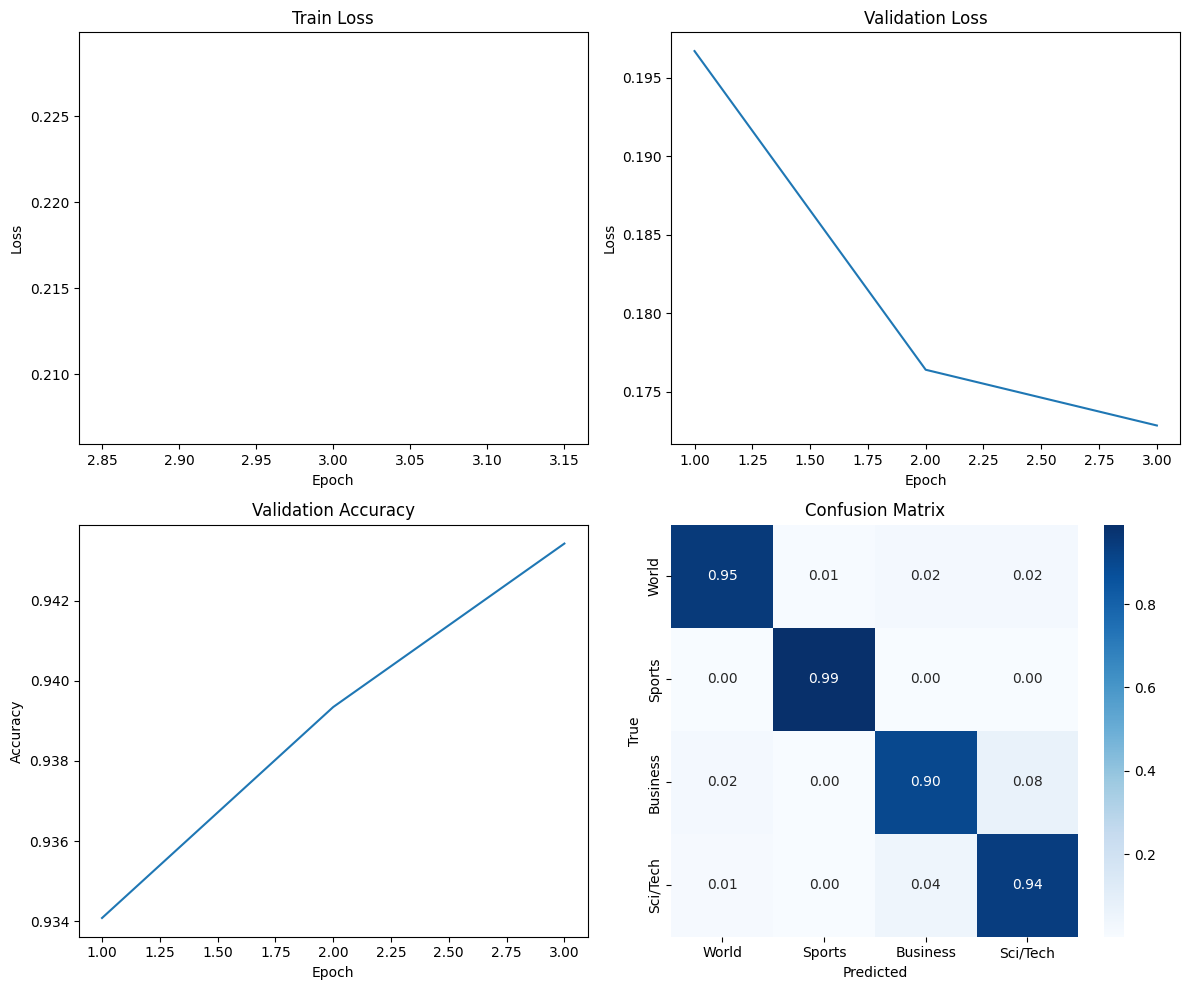

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predict:   0%|          | 0/250 [00:00<?, ?it/s]

,Decoded Text,Predicted Label
0,Remains of New Species of Hobbit-Sized Human F...,Sci/Tech
1,Iran to cease negotiations with EU in case of ...,World
2,Israel levels new accusations against Syria Wi...,World
3,Enevo a Silicon Valley startup create self-pow...,Sci/Tech
4,NBA owners have imposed a luxury tax change on...,Sports


In [15]:
data_module = AGNewsDataModule(
    model_name_or_path=MODEL_ID,
    data_dir=DATA_DIR,
    competition_name=COMPETITION_ID,
    batch_size=BATCH_SIZE,
    test_batch_size=TEST_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    max_seq_length=MAX_SEQ_LEN,
    val_split_percentage=VAL_SPLIT,
    filter_max_words = None,  # Increase significantly from 100
    filter_max_nonalpha_ratio = None, # Slighatly relax non-alpha ratio too
    apply_augmentation = False,
    
)

data_module.prepare_data() # Downloads HF data and competition data if needed
data_module.setup() # Sets up train, val, and test
train_dataset = data_module.get_train_loader().dataset # Get the underlying Dataset object
val_dataset = data_module.get_val_loader().dataset     # Get the underlying Dataset object
tokenizer = data_module.tokenizer                     # Get the tokenizer
data_collator = data_module.data_collator             # Get the data collator

lora_r = 8
lora_alpha = 16
lora_dropout = 0.1
target_modules = ["query", "value"]
learning_rate = 2e-4
train_batch_size = 32
eval_batch_size = 32
num_train_epochs = 3
weight_decay = 0.01
warmup_ratio = 0.1
label_smoothing_factor = 0.0

experiment_info = run_experiment(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        lora_r=lora_r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        target_modules=target_modules,
        learning_rate=learning_rate,
        train_batch_size=train_batch_size,
        eval_batch_size=eval_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        label_smoothing_factor=label_smoothing_factor
)

if experiment_info:
    view_df = inference_pipeline(
        output_dir=experiment_info['output_dir'],
        num_labels=4,
        adapter_path=experiment_info['adapter_dir'],
        eval_metrics=experiment_info["eval_metrics"],
        test_df=test_df,
        data_module=data_module,
    )
view_df.head()

## Experiment 2-3 (Increase r and alpha)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 962,308 || all params: 125,611,016 || trainable%: 0.7661


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.320900,0.201275,0.932895,0.933140,0.932895,0.932904
2,0.188100,0.180883,0.937500,0.937831,0.937500,0.937604
3,0.167600,0.174375,0.942368,0.942399,0.942368,0.942238
4,0.154500,0.172327,0.943684,0.943920,0.943684,0.943687


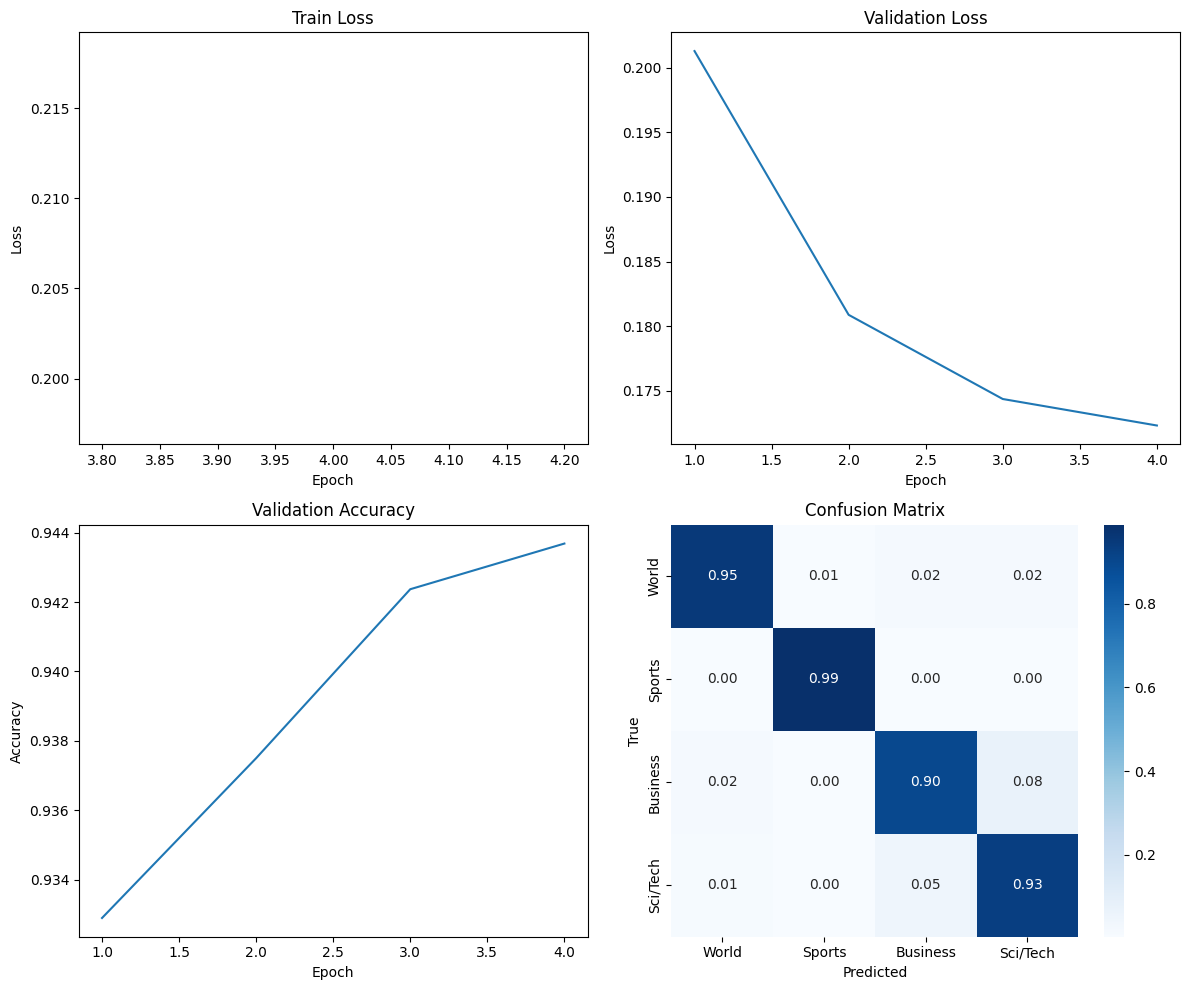

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predict:   0%|          | 0/250 [00:00<?, ?it/s]

,Decoded Text,Predicted Label
0,Remains of New Species of Hobbit-Sized Human F...,Sci/Tech
1,Iran to cease negotiations with EU in case of ...,World
2,Israel levels new accusations against Syria Wi...,World
3,Enevo a Silicon Valley startup create self-pow...,Sci/Tech
4,NBA owners have imposed a luxury tax change on...,Sports


In [16]:
data_module = AGNewsDataModule(
    model_name_or_path=MODEL_ID,
    data_dir=DATA_DIR,
    competition_name=COMPETITION_ID,
    batch_size=BATCH_SIZE,
    test_batch_size=TEST_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    max_seq_length=MAX_SEQ_LEN,
    val_split_percentage=VAL_SPLIT,
    filter_max_words = None,  # Increase significantly from 100
    filter_max_nonalpha_ratio = None, # Slighatly relax non-alpha ratio too
    apply_augmentation = False,
    
)

data_module.prepare_data() # Downloads HF data and competition data if needed
data_module.setup() # Sets up train, val, and test
train_dataset = data_module.get_train_loader().dataset # Get the underlying Dataset object
val_dataset = data_module.get_val_loader().dataset     # Get the underlying Dataset object
tokenizer = data_module.tokenizer                     # Get the tokenizer
data_collator = data_module.data_collator             # Get the data collator

lora_r = 10
lora_alpha = 16
lora_dropout = 0.1
target_modules = ["query", "value"]
learning_rate = 2e-4
train_batch_size = 32
eval_batch_size = 32
num_train_epochs = 4
weight_decay = 0.01
warmup_ratio = 0.1
label_smoothing_factor = 0.0

experiment_info = run_experiment(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        lora_r=lora_r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        target_modules=target_modules,
        learning_rate=learning_rate,
        train_batch_size=train_batch_size,
        eval_batch_size=eval_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        label_smoothing_factor=label_smoothing_factor
)

if experiment_info:
    view_df = inference_pipeline(
        output_dir=experiment_info['output_dir'],
        num_labels=4,
        adapter_path=experiment_info['adapter_dir'],
        eval_metrics=experiment_info["eval_metrics"],
        test_df=test_df,
        data_module=data_module,
    )
view_df.head()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 962,308 || all params: 125,611,016 || trainable%: 0.7661


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.306700,0.193795,0.934474,0.934742,0.934474,0.934496
2,0.182300,0.177935,0.940263,0.940453,0.940263,0.940297
3,0.161000,0.172492,0.944605,0.944549,0.944605,0.944526
4,0.146200,0.170443,0.946053,0.946176,0.946053,0.946041


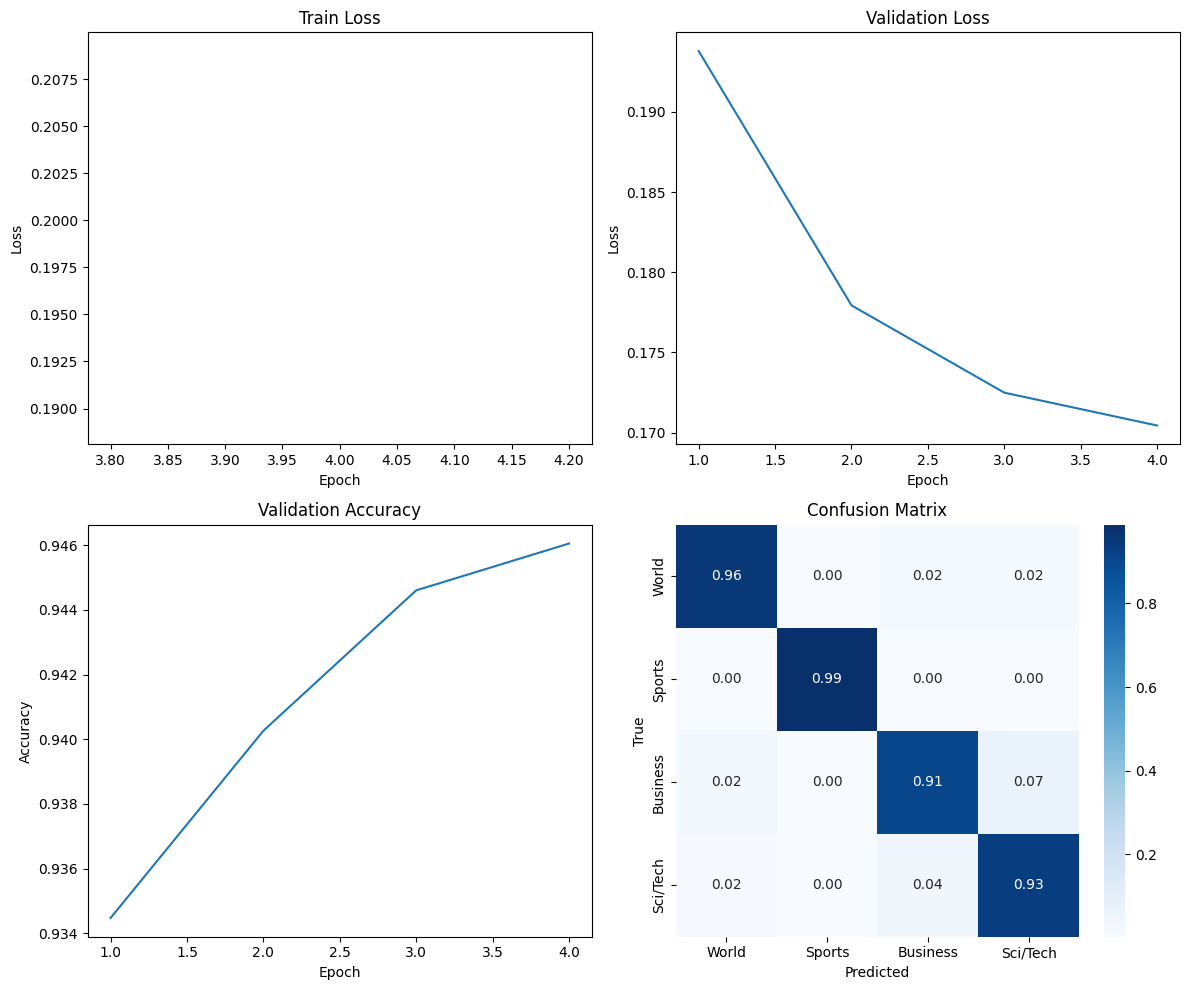

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predict:   0%|          | 0/250 [00:00<?, ?it/s]

,Decoded Text,Predicted Label
0,Remains of New Species of Hobbit-Sized Human F...,Sci/Tech
1,Iran to cease negotiations with EU in case of ...,World
2,Israel levels new accusations against Syria Wi...,World
3,Enevo a Silicon Valley startup create self-pow...,Sci/Tech
4,NBA owners have imposed a luxury tax change on...,Sports


In [17]:
data_module = AGNewsDataModule(
    model_name_or_path=MODEL_ID,
    data_dir=DATA_DIR,
    competition_name=COMPETITION_ID,
    batch_size=BATCH_SIZE,
    test_batch_size=TEST_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    max_seq_length=MAX_SEQ_LEN,
    val_split_percentage=VAL_SPLIT,
    filter_max_words = None,  # Increase significantly from 100
    filter_max_nonalpha_ratio = None, # Slighatly relax non-alpha ratio too
    apply_augmentation = False,
    
)

data_module.prepare_data() # Downloads HF data and competition data if needed
data_module.setup() # Sets up train, val, and test
train_dataset = data_module.get_train_loader().dataset # Get the underlying Dataset object
val_dataset = data_module.get_val_loader().dataset     # Get the underlying Dataset object
tokenizer = data_module.tokenizer                     # Get the tokenizer
data_collator = data_module.data_collator             # Get the data collator

lora_r = 10
lora_alpha = 32
lora_dropout = 0.1
target_modules = ["query", "value"]
learning_rate = 2e-4
train_batch_size = 32
eval_batch_size = 32
num_train_epochs = 4
weight_decay = 0.01
warmup_ratio = 0.1
label_smoothing_factor = 0.0

experiment_info = run_experiment(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        lora_r=lora_r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        target_modules=target_modules,
        learning_rate=learning_rate,
        train_batch_size=train_batch_size,
        eval_batch_size=eval_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        label_smoothing_factor=label_smoothing_factor
)

if experiment_info:
    view_df = inference_pipeline(
        output_dir=experiment_info['output_dir'],
        num_labels=4,
        adapter_path=experiment_info['adapter_dir'],
        eval_metrics=experiment_info["eval_metrics"],
        test_df=test_df,
        data_module=data_module,
    )
view_df.head()

## Experiment 4-6 (Diversifying Target Modules)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 925,444 || all params: 125,574,152 || trainable%: 0.7370


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.312100,0.181428,0.938026,0.938657,0.938026,0.938185
2,0.173600,0.169350,0.945000,0.945254,0.945000,0.945062
3,0.149600,0.163645,0.948684,0.949007,0.948684,0.948541
4,0.131900,0.168223,0.949868,0.950067,0.949868,0.949864
5,0.118300,0.170990,0.949342,0.949280,0.949342,0.949273


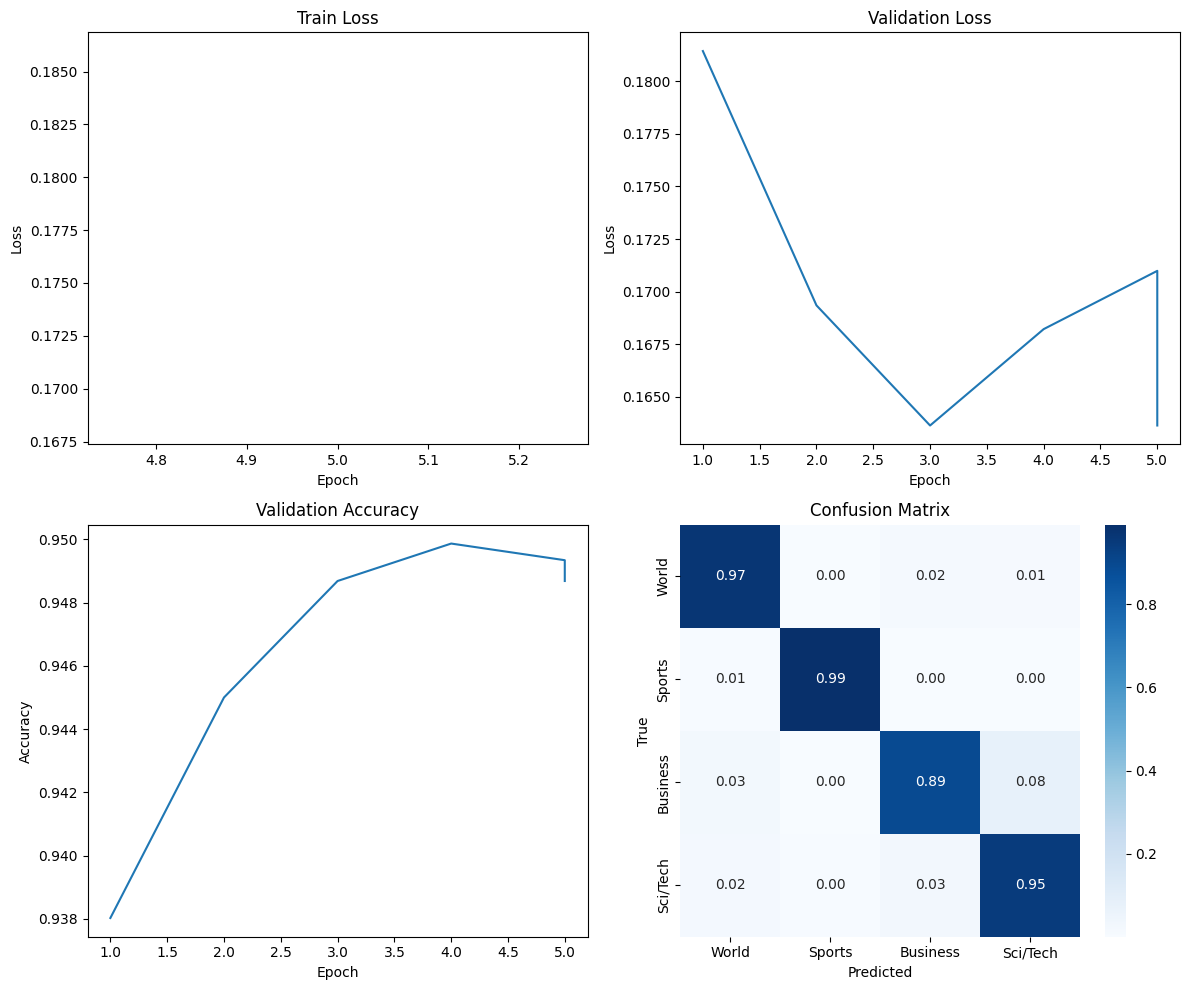

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predict:   0%|          | 0/250 [00:00<?, ?it/s]

,Decoded Text,Predicted Label
0,Remains of New Species of Hobbit-Sized Human F...,Sci/Tech
1,Iran to cease negotiations with EU in case of ...,World
2,Israel levels new accusations against Syria Wi...,World
3,Enevo a Silicon Valley startup create self-pow...,Sci/Tech
4,NBA owners have imposed a luxury tax change on...,Sports


In [18]:
data_module = AGNewsDataModule(
    model_name_or_path=MODEL_ID,
    data_dir=DATA_DIR,
    competition_name=COMPETITION_ID,
    batch_size=BATCH_SIZE,
    test_batch_size=TEST_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    max_seq_length=MAX_SEQ_LEN,
    val_split_percentage=VAL_SPLIT,
    filter_max_words = None,  # Increase significantly from 100
    filter_max_nonalpha_ratio = None, # Slighatly relax non-alpha ratio too
    apply_augmentation = False,
    
)

data_module.prepare_data() # Downloads HF data and competition data if needed
data_module.setup() # Sets up train, val, and test
train_dataset = data_module.get_train_loader().dataset # Get the underlying Dataset object
val_dataset = data_module.get_val_loader().dataset     # Get the underlying Dataset object
tokenizer = data_module.tokenizer                     # Get the tokenizer
data_collator = data_module.data_collator             # Get the data collator

lora_r = 2
lora_alpha = 12
lora_dropout = 0.1
target_modules = ["query", "key", "value", "intermediate.dense", "output.dense"]
learning_rate = 2e-4
train_batch_size = 32
eval_batch_size = 32
num_train_epochs = 6
weight_decay = 0.01
warmup_ratio = 0.1
label_smoothing_factor = 0.0

experiment_info = run_experiment(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        lora_r=lora_r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        target_modules=target_modules,
        learning_rate=learning_rate,
        train_batch_size=train_batch_size,
        eval_batch_size=eval_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        label_smoothing_factor=label_smoothing_factor
)

if experiment_info:
    view_df = inference_pipeline(
        output_dir=experiment_info['output_dir'],
        num_labels=4,
        adapter_path=experiment_info['adapter_dir'],
        eval_metrics=experiment_info["eval_metrics"],
        test_df=test_df,
        data_module=data_module,
    )
view_df.head()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 934,676 || all params: 125,592,616 || trainable%: 0.7442


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.315000,0.192828,0.936053,0.936799,0.936053,0.936146
2,0.175800,0.173187,0.941447,0.941650,0.941447,0.941466
3,0.152300,0.169608,0.946316,0.946459,0.946316,0.946152
4,0.134800,0.170352,0.945526,0.945886,0.945526,0.945612
5,0.119700,0.171880,0.950263,0.950248,0.950263,0.950170


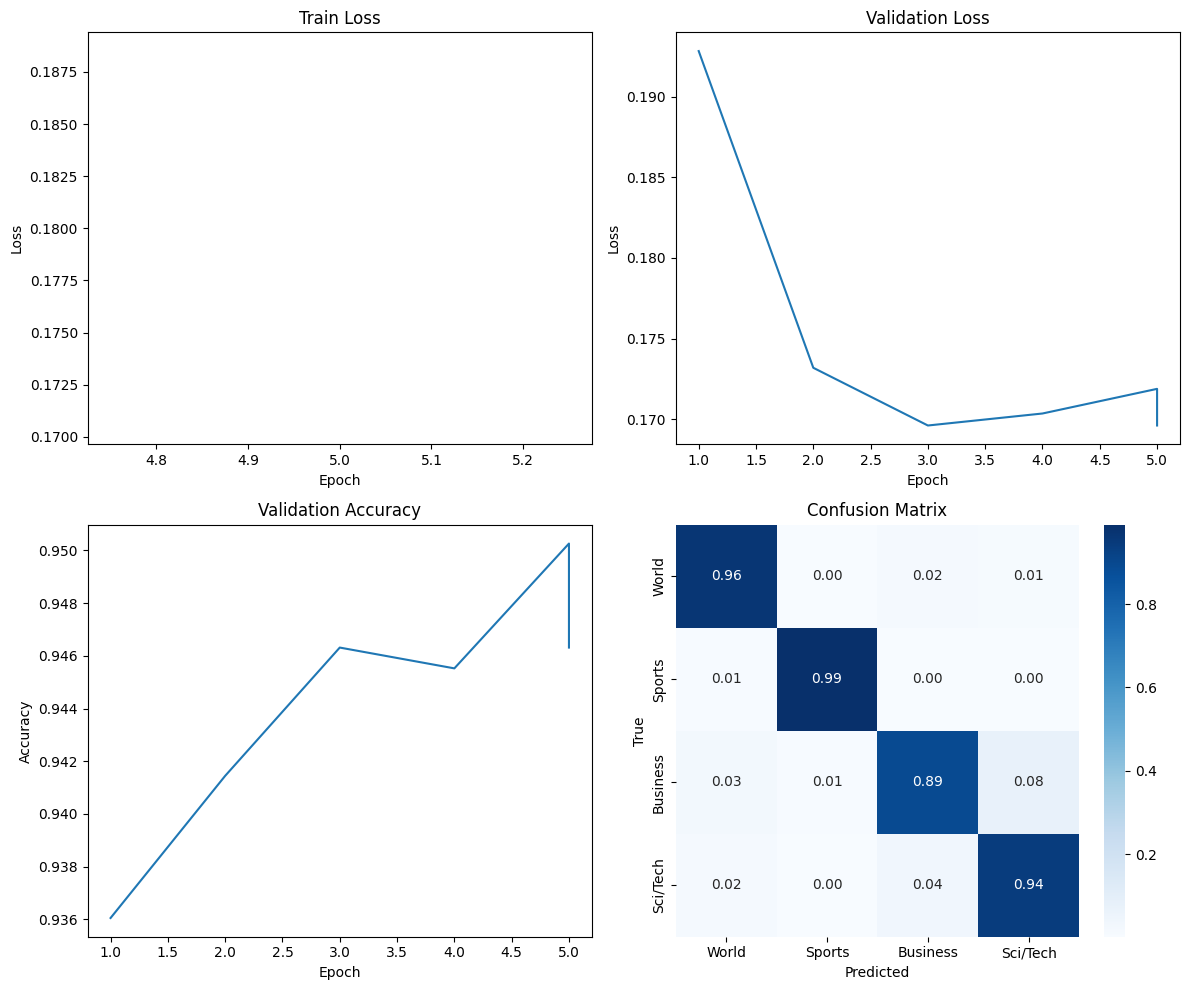

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:599: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.classifier.dense.lora_A.default.weight', 'base_model.model.classifier.dense.lora_B.default.weight', 'base_model.model.classifier.out_proj.lora_A.default.weight', 'base_model.model.classifier.out_proj.lora_B.default.weight']
  warnings.warn(f"Found missing adapter keys while loading the checkpoint: {missing_keys}")


Predict:   0%|          | 0/250 [00:00<?, ?it/s]

,Decoded Text,Predicted Label
0,Remains of New Species of Hobbit-Sized Human F...,Sports
1,Iran to cease negotiations with EU in case of ...,World
2,Israel levels new accusations against Syria Wi...,World
3,Enevo a Silicon Valley startup create self-pow...,Sports
4,NBA owners have imposed a luxury tax change on...,Sports


In [19]:
data_module = AGNewsDataModule(
    model_name_or_path=MODEL_ID,
    data_dir=DATA_DIR,
    competition_name=COMPETITION_ID,
    batch_size=BATCH_SIZE,
    test_batch_size=TEST_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    max_seq_length=MAX_SEQ_LEN,
    val_split_percentage=VAL_SPLIT,
    filter_max_words = None,  # Increase significantly from 100
    filter_max_nonalpha_ratio = None, # Slighatly relax non-alpha ratio too
    apply_augmentation = False,
    
)

data_module.prepare_data() # Downloads HF data and competition data if needed
data_module.setup() # Sets up train, val, and test
train_dataset = data_module.get_train_loader().dataset # Get the underlying Dataset object
val_dataset = data_module.get_val_loader().dataset     # Get the underlying Dataset object
tokenizer = data_module.tokenizer                     # Get the tokenizer
data_collator = data_module.data_collator             # Get the data collator


lora_r = 4
lora_alpha = 24
lora_dropout = 0.1
target_modules = ["query", "value", "intermediate.dense", "classifier.dense","classifier.out_proj"]
learning_rate = 2e-4
train_batch_size = 32
eval_batch_size = 32
num_train_epochs = 6
weight_decay = 0.01
warmup_ratio = 0.1
label_smoothing_factor = 0.0

experiment_info = run_experiment(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        lora_r=lora_r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        target_modules=target_modules,
        learning_rate=learning_rate,
        train_batch_size=train_batch_size,
        eval_batch_size=eval_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        label_smoothing_factor=label_smoothing_factor
)

if experiment_info:
    view_df = inference_pipeline(
        output_dir=experiment_info['output_dir'],
        num_labels=4,
        adapter_path=experiment_info['adapter_dir'],
        eval_metrics=experiment_info["eval_metrics"],
        test_df=test_df,
        data_module=data_module,
    )
view_df.head()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 985,388 || all params: 125,657,176 || trainable%: 0.7842


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.326800,0.196519,0.933026,0.932975,0.933026,0.932963
2,0.187100,0.182242,0.939868,0.939785,0.939868,0.939782
3,0.164800,0.177886,0.942763,0.942870,0.942763,0.942535
4,0.149900,0.170281,0.946184,0.946517,0.946184,0.946264
5,0.136700,0.177434,0.946842,0.946939,0.946842,0.946808
6,0.128600,0.171119,0.949079,0.949212,0.949079,0.949085


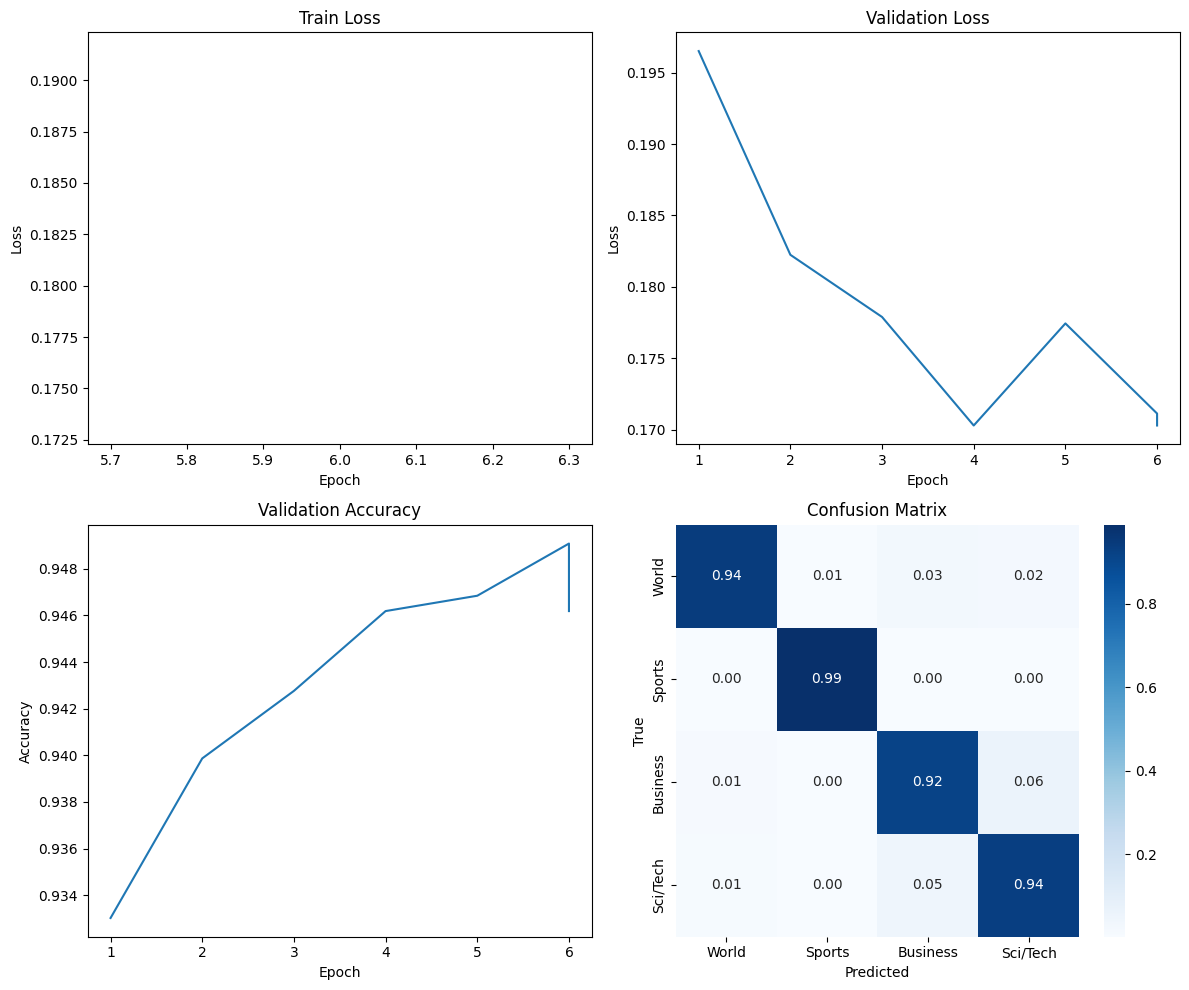

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:599: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.classifier.dense.lora_A.default.weight', 'base_model.model.classifier.dense.lora_B.default.weight', 'base_model.model.classifier.out_proj.lora_A.default.weight', 'base_model.model.classifier.out_proj.lora_B.default.weight']
  warnings.warn(f"Found missing adapter keys while loading the checkpoint: {missing_keys}")


Predict:   0%|          | 0/250 [00:00<?, ?it/s]

,Decoded Text,Predicted Label
0,Remains of New Species of Hobbit-Sized Human F...,Business
1,Iran to cease negotiations with EU in case of ...,Business
2,Israel levels new accusations against Syria Wi...,Business
3,Enevo a Silicon Valley startup create self-pow...,Sports
4,NBA owners have imposed a luxury tax change on...,Business


In [20]:
data_module = AGNewsDataModule(
    model_name_or_path=MODEL_ID,
    data_dir=DATA_DIR,
    competition_name=COMPETITION_ID,
    batch_size=BATCH_SIZE,
    test_batch_size=TEST_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    max_seq_length=MAX_SEQ_LEN,
    val_split_percentage=VAL_SPLIT,
    filter_max_words = None,  # Increase significantly from 100
    filter_max_nonalpha_ratio = None, # Slighatly relax non-alpha ratio too
    apply_augmentation = False,
    
)

data_module.prepare_data() # Downloads HF data and competition data if needed
data_module.setup() # Sets up train, val, and test
train_dataset = data_module.get_train_loader().dataset # Get the underlying Dataset object
val_dataset = data_module.get_val_loader().dataset     # Get the underlying Dataset object
tokenizer = data_module.tokenizer                     # Get the tokenizer
data_collator = data_module.data_collator             # Get the data collator


lora_r = 10
lora_alpha = 32
target_modules = ["query", "value", "classifier.dense","classifier.out_proj"]
lora_dropout = 0.1
learning_rate = 2e-4
train_batch_size = 32
eval_batch_size = 32
num_train_epochs = 6
weight_decay = 0.01
warmup_ratio = 0.1
label_smoothing_factor = 0.0

experiment_info = run_experiment(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        lora_r=lora_r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        target_modules=target_modules,
        learning_rate=learning_rate,
        train_batch_size=train_batch_size,
        eval_batch_size=eval_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        label_smoothing_factor=label_smoothing_factor
)

if experiment_info:
    view_df = inference_pipeline(
        output_dir=experiment_info['output_dir'],
        num_labels=4,
        adapter_path=experiment_info['adapter_dir'],
        eval_metrics=experiment_info["eval_metrics"],
        test_df=test_df,
        data_module=data_module,
    )
view_df.head()

## Experiment 7-8 (Regularization, Data Augmentation, Filtration)

Filter (num_proc=2):   0%|          | 0/120000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/118179 [00:00<?, ? examples/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1a7f9119e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1a7f9119e0> 
  Traceback (most recent call last):
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      self._shutdown_workers() 
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^^ ^ ^ ^ ^ ^^^^^^^^^^^^^

Map (num_proc=2):   0%|          | 0/7600 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 985,388 || all params: 125,657,176 || trainable%: 0.7842


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.309500,0.194677,0.936053,0.936317,0.936053,0.936000
2,0.183200,0.180229,0.939868,0.940460,0.939868,0.939889
3,0.162800,0.175159,0.945395,0.945375,0.945395,0.945378
4,0.148300,0.169912,0.945658,0.945707,0.945658,0.945569


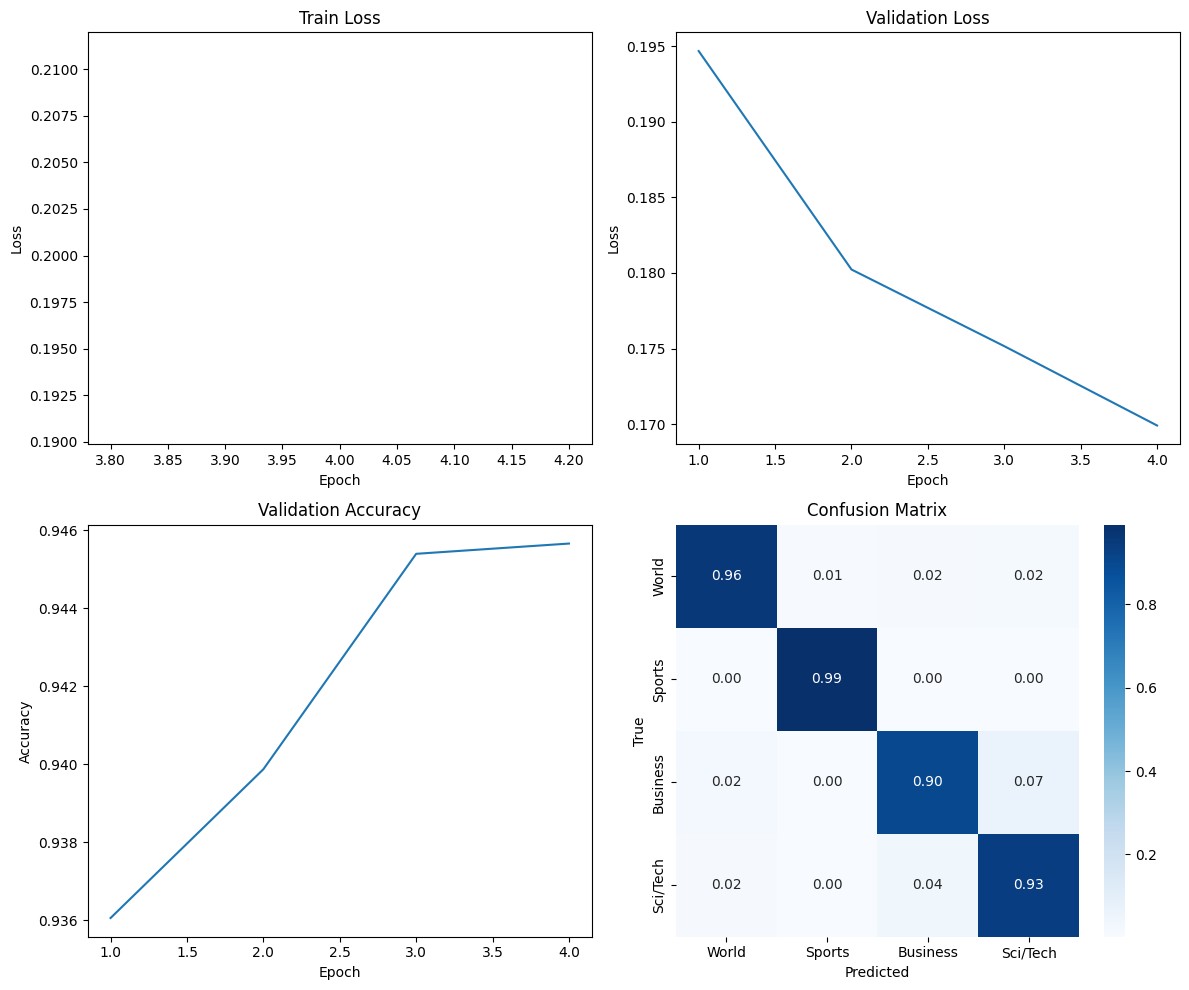

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:599: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.classifier.dense.lora_A.default.weight', 'base_model.model.classifier.dense.lora_B.default.weight', 'base_model.model.classifier.out_proj.lora_A.default.weight', 'base_model.model.classifier.out_proj.lora_B.default.weight']
  warnings.warn(f"Found missing adapter keys while loading the checkpoint: {missing_keys}")


Predict:   0%|          | 0/250 [00:00<?, ?it/s]

,Decoded Text,Predicted Label
0,Remains of New Species of Hobbit-Sized Human F...,Sports
1,Iran to cease negotiations with EU in case of ...,Sports
2,Israel levels new accusations against Syria Wi...,Sports
3,Enevo a Silicon Valley startup create self-pow...,Sports
4,NBA owners have imposed a luxury tax change on...,Sports


In [21]:
data_module = AGNewsDataModule(
    model_name_or_path=MODEL_ID,
    data_dir=DATA_DIR,
    competition_name=COMPETITION_ID,
    batch_size=BATCH_SIZE,
    test_batch_size=TEST_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    max_seq_length=MAX_SEQ_LEN,
    val_split_percentage=VAL_SPLIT,
    filter_max_words = 100,  # Increase significantly from 100
    filter_max_nonalpha_ratio = 0.1, # Slighatly relax non-alpha ratio too
    apply_augmentation = True,
    
)

data_module.prepare_data() # Downloads HF data and competition data if needed
data_module.setup() # Sets up train, val, and test
train_dataset = data_module.get_train_loader().dataset # Get the underlying Dataset object
val_dataset = data_module.get_val_loader().dataset     # Get the underlying Dataset object
tokenizer = data_module.tokenizer                     # Get the tokenizer
data_collator = data_module.data_collator             # Get the data collator

lora_r = 10
lora_alpha = 32
target_modules = ["query", "value", "classifier.dense","classifier.out_proj"]
lora_dropout = 0.1
learning_rate = 2e-4
train_batch_size = 32
eval_batch_size = 32
num_train_epochs = 4
weight_decay = 0.01
warmup_ratio = 0.1
label_smoothing_factor = 0.0

experiment_info = run_experiment(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        lora_r=lora_r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        target_modules=target_modules,
        learning_rate=learning_rate,
        train_batch_size=train_batch_size,
        eval_batch_size=eval_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        label_smoothing_factor=label_smoothing_factor
)

if experiment_info:
    view_df = inference_pipeline(
        output_dir=experiment_info['output_dir'],
        num_labels=4,
        adapter_path=experiment_info['adapter_dir'],
        eval_metrics=experiment_info["eval_metrics"],
        test_df=test_df,
        data_module=data_module,
    )
view_df.head()

In [ ]:
data_module = AGNewsDataModule(
    model_name_or_path=MODEL_ID,
    data_dir=DATA_DIR,
    competition_name=COMPETITION_ID,
    batch_size=BATCH_SIZE,
    test_batch_size=TEST_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    max_seq_length=MAX_SEQ_LEN,
    val_split_percentage=VAL_SPLIT,
    filter_max_words = None,  # Increase significantly from 100
    filter_max_nonalpha_ratio = None, # Slighatly relax non-alpha ratio too
    apply_augmentation = None,
    
)

data_module.prepare_data() # Downloads HF data and competition data if needed
data_module.setup() # Sets up train, val, and test
train_dataset = data_module.get_train_loader().dataset # Get the underlying Dataset object
val_dataset = data_module.get_val_loader().dataset     # Get the underlying Dataset object
tokenizer = data_module.tokenizer                     # Get the tokenizer
data_collator = data_module.data_collator             # Get the data collator

lora_r = 10
lora_alpha = 32
target_modules = ["query", "value", "classifier.dense","classifier.out_proj"]
lora_dropout = 0.15
learning_rate = 2e-4
train_batch_size = 32
eval_batch_size = 32
num_train_epochs = 4
weight_decay = 0.01
warmup_ratio = 0.15
label_smoothing_factor = 0.1

experiment_info = run_experiment(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        lora_r=lora_r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        target_modules=target_modules,
        learning_rate=learning_rate,
        train_batch_size=train_batch_size,
        eval_batch_size=eval_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        label_smoothing_factor=label_smoothing_factor
)

if experiment_info:
    view_df = inference_pipeline(
        output_dir=experiment_info['output_dir'],
        num_labels=4,
        adapter_path=experiment_info['adapter_dir'],
        eval_metrics=experiment_info["eval_metrics"],
        test_df=test_df,
        data_module=data_module,
    )
view_df.head()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (344441286.py, line 11)